# NATURAL LANGUAGE PROCESSING
## Mini Project 1 – Text Generation

### Import Libraries

In [528]:
import nltk
from nltk.util import ngrams
from nltk.tokenize import word_tokenize
from collections import defaultdict
import string
import math
import numpy as np
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.probability import FreqDist


### Loading Data

#### Load khmer_food.txt

In [529]:
with open('khmer_food.txt', 'r', encoding='utf-8') as file:
    corpus = file.read()

#### Display First 200 sentences

In [530]:
sentences = nltk.sent_tokenize(corpus)

print("Number of sentences in the file:", len(sentences))

Number of sentences in the file: 1372


#### Split the corpus into training, validation, and test sets

In [531]:
# Assuming 'sentences' is your data from the previous code snippet
# If not, replace it with the appropriate variable holding your data

# Split the data into train, test, and validation sets
train_data, temp_data = train_test_split(sentences, test_size=0.3, random_state=42)
test_data, val_data = train_test_split(temp_data, test_size=0.1, random_state=42)

# Print the number of sentences in each set
print("Number of sentences in the training set:", len(train_data))
print("Number of sentences in the testing set:", len(test_data))
print("Number of sentences in the validation set:", len(val_data))


Number of sentences in the training set: 960
Number of sentences in the testing set: 370
Number of sentences in the validation set: 42


### Tokenize the Text

### Exploratory Data Analysis (EDA)

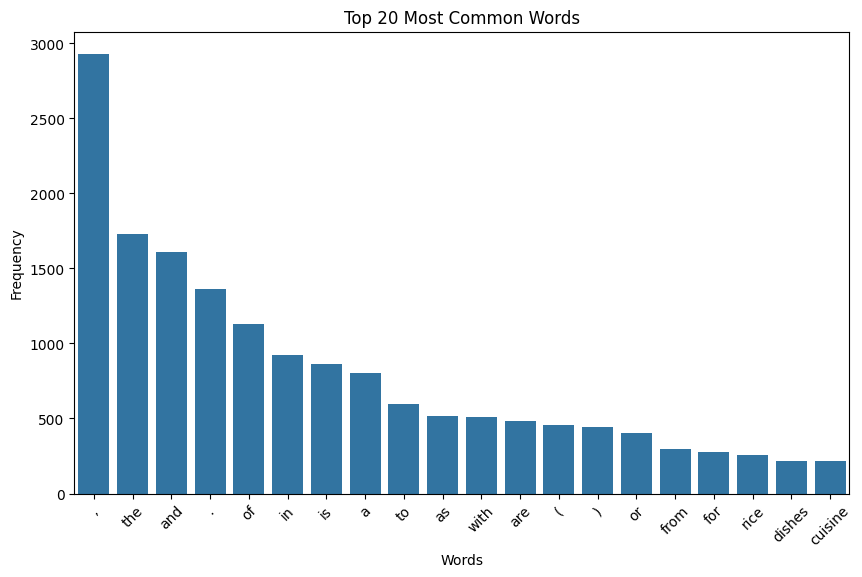

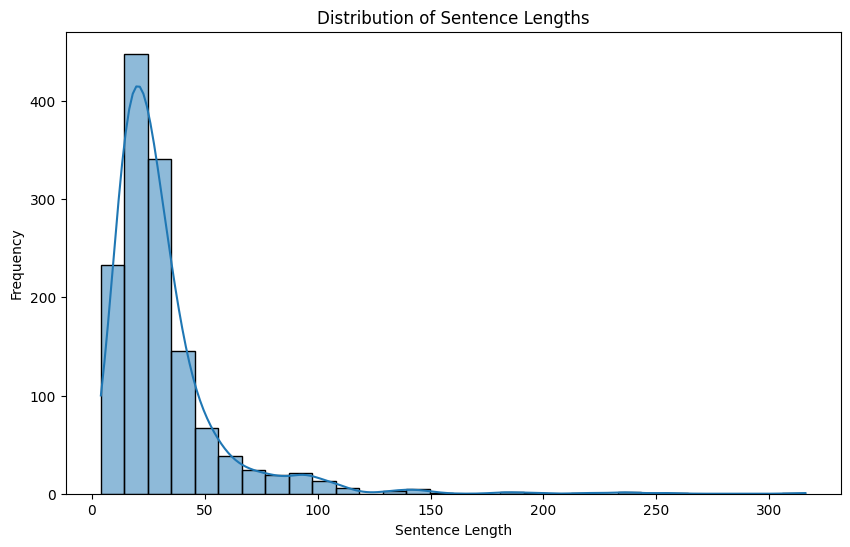

In [532]:

# Tokenize the entire corpus
tokens = word_tokenize(corpus.lower())

# Frequency Distribution of words
freq_dist = FreqDist(tokens)

# Plot the top N most common words
top_words = freq_dist.most_common(20)
plt.figure(figsize=(10, 6))
sns.barplot(x=[word[0] for word in top_words], y=[word[1] for word in top_words])
plt.title('Top 20 Most Common Words')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

# Plot the distribution of sentence lengths
sentence_lengths = [len(word_tokenize(sentence)) for sentence in sentences]
plt.figure(figsize=(10, 6))
sns.histplot(sentence_lengths, bins=30, kde=True)
plt.title('Distribution of Sentence Lengths')
plt.xlabel('Sentence Length')
plt.ylabel('Frequency')
plt.show()

#### Basic Statistics of tokens

#### Frequency Distribution

#### Visualization - Word Cloud

### Pre-Processing the Data

Complete function below which
+ Convert lower case
+ Remove emoji
+ Split each sentence into tokens
+ Remove punctuation


In [533]:
def remove_rare_words(data, vocab, mincount = 1):
    # replace words in data that are not in the vocab 
    # or have a count that is below mincount
    data_with_unk = []
    ## FILL CODE
    for sentence in data:
        sentence_with_unk = []
        for word in sentence:
            if word in vocab and vocab[word]>mincount:
                sentence_with_unk.append(word)
            else:
                sentence_with_unk.append('<unk>')
        data_with_unk.append(sentence_with_unk)
    
    return data_with_unk

In [534]:
def tokenize_text(sentences, vocab_size, min_count=1):
    # Join sentences into a single text string
    text = ' '.join(sentences)
    
    # Tokenize into unigrams
    unigrams = word_tokenize(text.lower())
    unigrams = [token for token in unigrams if token not in string.punctuation]
    
    # Calculate frequency distribution of unigrams
    freq_dist = FreqDist(unigrams)
    
    # Remove rare words
    unigrams = remove_rare_words([unigrams], freq_dist, min_count)[0]
    
    # Get the most common tokens up to vocab_size
    vocab = [token for token, _ in freq_dist.most_common(vocab_size)]
    
    # Filter unigrams based on vocabulary size
    unigrams = [token if token in vocab else '<UNK>' for token in unigrams]
    
    # Tokenize into bigrams
    bigrams = list(ngrams(unigrams, 2))
    
    return unigrams, bigrams


### Build 4-gram language model using backoff method

In [535]:
def get_prob(model, context, w):

    if context in model and w in model[context]:
        return model[context][w]
    else:
        return 0.4*get_prob(model, context[1:], w)

In [536]:
def get_proba_distrib(model, context):
    
    if context in model:
        return model[context]
    else:
        return get_proba_distrib(model, context[1:])

In [537]:
# Build n-gram model
def build_ngram(data, n):
    total_number_words = 0
    counts = defaultdict(lambda: defaultdict(lambda: 0.0))

    for sentence in data:
        for i in range(len(sentence)):
            total_number_words += 1
            for k in range(n):
                if i - k < 0:
                    break
                counts[sentence[i-k:i]][sentence[i]] += 1

    proba = defaultdict(lambda: defaultdict(lambda: 0.0))
    for context in counts.keys():
        denom = sum(counts[context].values())
        for w in counts[context].keys():
            proba[context][w] = counts[context][w] / denom

    return proba

In [538]:
# Generate text
def generate(model):
    sentence = ["Khmer", "cuisine", "combines"]
    while sentence[-1] != "</s>" and len(sentence) < 100:
        proba = get_proba_distrib(model, tuple(sentence))
        w = np.random.choice(list(proba.keys()), 1, p=list(proba.values()))
        sentence.append(w[0])
    return sentence


In [539]:
def perplexity(model, data, n):
    perp, T = 0.0, 0
    for sentence in data:
        for i in range(1, len(sentence)):
            nc = min(n - 1, i)
            context = tuple(sentence[i-nc:i])  # Convert context to a tuple
            perp += -math.log(get_prob(model, context, sentence[i]))
            T += 1
    perp = math.exp(perp/T)
    return perp

In [543]:
# Test data
vocab_size = 10000
test_unigrams, test_bigrams = tokenize_text(test_data, vocab_size)

# Build n-gram model for bigrams
n = 4
model = build_ngram(test_bigrams, n)

# Generate a sentence
print("Generated sentence:", ' '.join(generate(model)))

# Evaluate perplexity
perplexity_score = perplexity(model, test_bigrams, n)
print("Perplexity:", perplexity_score)


Generated sentence: Khmer cuisine combines <UNK> of all traditional chinese people when <UNK> in seattle leche flan made from the <UNK> chinese malaysian diet is a <UNK> the xianbei northern dishes in the use of food to five <UNK> <UNK> restaurants and cambodians usually made from <UNK> from pastries and the 2021 gourmand world cookbook '' and wild plants vietnamese cuisine cookbook award as <UNK> '' is still <UNK> <UNK> three main meal may be served after the best asian beers in <UNK> together and <UNK> omelettes called <UNK> some notable that is one of many <UNK> laing or <UNK> after a
Perplexity: 15.391509050452543


### Build 4-gram language model using interpolation method with add-k smoothing

### Evaluate perplexity of a language model on a test set

In [541]:
# Write your code here

### Generate text using the language model

### Generate the next word given the previous tokens

## Runing Code ......

In [542]:
# wrtie your code here 